# IMPORT MODULES

In [44]:
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
import scipy.stats
import statistics
import math
import sys
import os


## Import, Clean, and Examine Data
## (only needs to run when fresh data input)

In [45]:
data= pd.read_csv('./challenge.csv')

In [46]:
##examine headers
data.head()

,year,gameid,tm_home,tm_score,opp_score,month,day,tm_ot,opp_ot,line_p,...,tot_p_omon_h1,tot_p_umon_h1,tm_h1,tm_h2,opp_h1,opp_h2,season,week,tmid,oppid
0,2007,2875,1,13,14,8,30,NaN,NaN,-4.0,...,-114.0,104.0,3.0,10.0,7.0,7.0,2007,1,17,107
1,2007,2875,0,14,13,8,30,NaN,NaN,4.0,...,-114.0,104.0,7.0,7.0,3.0,10.0,2007,1,107,17
2,2007,2878,1,14,23,8,30,NaN,NaN,-3.5,...,NaN,NaN,7.0,7.0,9.0,14.0,2007,1,82,88
3,2007,2878,0,23,14,8,30,NaN,NaN,3.5,...,NaN,NaN,9.0,14.0,7.0,7.0,2007,1,88,82
4,2007,2879,0,35,17,8,30,NaN,NaN,-3.5,...,NaN,NaN,14.0,21.0,17.0,0.0,2007,1,202,97


In [47]:
##Create columns for first half score as a difference and as a total instead of tm and opp.
data['diff_h1']=data['opp_h1']-data['tm_h1']
data['tot_h1']=data['opp_h1']+data['tm_h1']

##reduce number of columns to just information required
data_simp = data.drop(columns=['tm_home','tm_score','opp_score','month','day','tm_ot','opp_ot','tmid','oppid','year','tm_h2','opp_h2','tm_h1','opp_h1'])

##check how many lines have no NANs for each column
print(data_simp.count())


gameid           20420
line_p           20420
line_p_mon       20420
tot_p            19053
tot_p_omon       19055
tot_p_umon       19054
line_p_h1        18702
line_p_mon_h1    18702
tot_p_h1         18557
tot_p_omon_h1    18557
tot_p_umon_h1    18558
season           20420
week             20420
diff_h1          18464
tot_h1           18464
dtype: int64


In [48]:
##appears to be enough rows without NaN's for the model so just use rows with full data for simplicity
data_clean = data_simp.dropna()

##check results dataframe shape is as expected
print(data_clean.count())

gameid           16912
line_p           16912
line_p_mon       16912
tot_p            16912
tot_p_omon       16912
tot_p_umon       16912
line_p_h1        16912
line_p_mon_h1    16912
tot_p_h1         16912
tot_p_omon_h1    16912
tot_p_umon_h1    16912
season           16912
week             16912
diff_h1          16912
tot_h1           16912
dtype: int64


In [49]:
##Examine data to check for outliers that could be errors, and as a basis for future assumptions/simplifications.

## show how many in each year for train/test data dividing purposes. 
print(data_clean[['season','gameid']].groupby('season').count())

##include median and +/- 1,2,3 standard deviatons
data_clean.describe(percentiles=[.0015,.02,.16,.5,.84,.98,.9985])


        gameid
season        
2007      1238
2008       628
2009      1294
2010      1290
2011      1422
2012      1420
2013      1438
2014      1470
2015      1508
2016      1508
2017      1362
2018      1518
2020       816


,gameid,line_p,line_p_mon,tot_p,tot_p_omon,tot_p_umon,line_p_h1,line_p_mon_h1,tot_p_h1,tot_p_omon_h1,tot_p_umon_h1,season,week,diff_h1,tot_h1
count,16912.000000,16912.000000,16912.000000,16912.000000,16912.000000,16912.000000,16912.000000,16912.000000,16912.000000,16912.00000,16912.000000,16912.000000,16912.000000,16912.000000,16912.000000
mean,8450.176325,-0.002129,-74.814037,55.440397,-86.305582,-85.735691,-0.001478,-51.460620,28.211566,-48.78329,-60.303867,2013.229541,8.186258,-0.000414,28.876242
std,3032.334726,14.540965,75.703845,8.057865,62.352810,62.968511,8.501310,95.463757,4.342940,96.96284,90.936593,3.603549,4.093587,14.901849,12.198402
min,2875.000000,-54.500000,-147.000000,34.000000,-154.000000,-133.000000,-35.500000,-160.000000,16.500000,-165.00000,-162.000000,2007.000000,1.000000,-59.000000,0.000000
0.2%,2896.366500,-44.000000,-126.000000,37.000000,-127.000000,-125.000000,-27.316750,-135.633500,18.500000,-138.00000,-142.000000,2007.000000,1.000000,-45.000000,0.000000
2%,3127.000000,-31.000000,-117.000000,41.000000,-116.000000,-116.000000,-18.000000,-125.000000,20.500000,-126.00000,-127.000000,2007.000000,1.000000,-31.000000,7.000000
16%,5018.520000,-14.000000,-110.000000,47.500000,-110.000000,-110.000000,-7.500000,-114.000000,24.000000,-114.00000,-115.000000,2009.000000,3.000000,-14.000000,17.000000
50%,8441.500000,0.000000,-106.000000,54.500000,-106.000000,-106.000000,0.000000,-106.000000,27.750000,-106.00000,-106.000000,2013.000000,8.000000,0.000000,28.000000
84%,11867.240000,14.000000,-100.000000,63.500000,-102.000000,-102.000000,7.500000,102.000000,33.000000,102.00000,101.000000,2017.000000,13.000000,14.000000,41.000000
98%,14088.000000,31.000000,105.000000,74.000000,103.000000,104.000000,18.000000,111.000000,38.000000,113.00000,111.000000,2020.000000,16.000000,31.000000,56.000000


In [50]:
##Since we're assuming just the full game spread/total as efficient, need to make my own simple 1h spread/total model
##SIMPLIFICATION 
    ## Data desciption table above shows almost all spread/total moneylines have roughly 50/50 implied probably. 
    ## To simplify first pass model, I'm going to assume the full game spread/total listed ARE the median 50/50 point...
    ## and not adjust for exact ML value for 1H predictor model.

##SIMPLIFICATON - Remove Entries with Full game spread between 2.5 and -2.5 since aren't likely to corroleate to total
data_clean_no2p5=data_clean[data_clean.line_p<-2.5].append(data_clean[data_clean.line_p>2.5])

##Seperate into train and test by year. 
##Train on 2007 to 2015, test 2016-2018.  REMOVE 2020 data because it's an odd covid year. about 25/75 train test split 
##2019 was already removed during NaN filtering because it had no H1 data. 
##SIMPLIFICATION - should weigh recent years more if we were really trying to predict an upcoming season, but won't here for simplificity
data_test = data_clean_no2p5[data_clean_no2p5.season>=2016][data_clean_no2p5.season!=2020]
data_train = data_clean_no2p5[data_clean_no2p5.season<=2015]

## check split
print(data_test[['season','gameid']].groupby('season').count())
print(data_test.shape)
print(data_train[['season','gameid']].groupby('season').count())
print(data_train.shape)

        gameid
season        
2016      1354
2017      1208
2018      1332
(3894, 15)
        gameid
season        
2007      1100
2008       522
2009      1154
2010      1138
2011      1252
2012      1224
2013      1300
2014      1294
2015      1326
(10310, 15)


## Developing Linear Regression for 1H lines based on full game lines
## (only needs to run when fresh data input)


In [51]:
#linear regression to predict 1h diff and total using closing full game lines. still assumes these are all the 50/50 spreads/totals.
# SIMPLIFICATION - in reality would need to adjust the predicted 1h lines so they make sense relative to key numbers (-3, 49 etc)

 
X_diff=data_train[['line_p']]
X_tot=data_train[['tot_p']]
y_diff_h1=data_train[['diff_h1']]
y_tot_h1=data_train[['tot_h1']]
reg_diff_h1 = LinearRegression().fit(X_diff, y_diff_h1)
reg_tot_h1 = LinearRegression().fit(X_tot, y_tot_h1)

#compare predictions of 1H lines against results and against the real closing line (should be very close to closing lines)
X_test_diff=data_test[['line_p']]
X_test_tot=data_test[['tot_p']]
y_test_diff_results=data_test[['diff_h1']]
y_test_diff_line=data_test[['line_p_h1']]
y_test_tot_results=data_test[['tot_h1']]
y_test_tot_line=data_test[['tot_p_h1']]

y_pred_diff = reg_diff_h1.predict(X_test_diff)
y_pred_tot = reg_tot_h1.predict(X_test_tot)

print(' Coefficients diff: \n', reg_diff_h1.coef_)
# RMSE is standard deviation of the results of the predictor. Used later for making distrobution 
print('\n RMS Error for Predicted Difference vs RESULTS: %.2f'
      % mean_squared_error(y_test_diff_results, y_pred_diff, squared=False))

# The coefficient of determination: 1 is perfect prediction
print(' R^2 Predicted Difference vs Results: %.2f'
      % r2_score(y_test_diff_results, y_pred_diff))
print('\n Root Mean squared error Predicted Difference vs Closing Line: %.2f'
      % mean_squared_error(y_test_diff_line, y_pred_diff,squared=False))
print(' R^2 Predicted Difference vs Closing Line: %.2f'
      % r2_score(y_test_diff_line, y_pred_diff))
print('\n How good of a predictor is the closing 1H line for comparison?')
print('   RMS Error for Closing 1H Spread vs 1H results: %.2f'
      % mean_squared_error(y_test_diff_line, y_test_diff_results,squared=False))
print('   R^2 for Closing 1H Spread vs 1H results: %.2f'
      % r2_score(data_test[['diff_h1']], data_test[['line_p_h1']]))

print('\n Coefficients tot: \n', reg_tot_h1.coef_)
print('\n RMS Error Predicted Total vs RESULTS: %.2f'
      % mean_squared_error(y_test_tot_results, y_pred_tot,squared=False))

print(' R^2 Predicted Total vs RESULTS: %.2f'
      % r2_score(y_test_tot_results, y_pred_tot))
print('\n RMS Error for Predicted Total versus Closing Line: %.2f'
      % mean_squared_error(y_test_tot_line,y_pred_tot,squared=False))
print(' R^2 for Predicted Total versus Closing Line: %.2f'
      % r2_score(y_test_tot_line, y_pred_tot))
print('\n How good of a predictor is the closing 1H line for comparison?')
print('   RMS Error for Closing 1H Total vs 1H Results: %.2f'
      % mean_squared_error(y_test_tot_line, y_test_tot_results,squared=False))
print('   R^2 for Closing 1H Total vs 1H Results: %.2f'
      % r2_score(data_test[['tot_h1']], data_test[['tot_p_h1']]))




 Coefficients diff: 
 [[0.6074788]]

 RMS Error for Predicted Difference vs RESULTS: 12.25
 R^2 Predicted Difference vs Results: 0.38

 Root Mean squared error Predicted Difference vs Closing Line: 0.70
 R^2 Predicted Difference vs Closing Line: 0.99

 How good of a predictor is the closing 1H line for comparison?
   RMS Error for Closing 1H Spread vs 1H results: 12.26
   R^2 for Closing 1H Spread vs 1H results: 0.38

 Coefficients tot: 
 [[0.55197777]]

 RMS Error Predicted Total vs RESULTS: 11.43
 R^2 Predicted Total vs RESULTS: 0.15

 RMS Error for Predicted Total versus Closing Line: 1.25
 R^2 for Predicted Total versus Closing Line: 0.93

 How good of a predictor is the closing 1H line for comparison?
   RMS Error for Closing 1H Total vs 1H Results: 11.43
   R^2 for Closing 1H Total vs 1H Results: 0.15


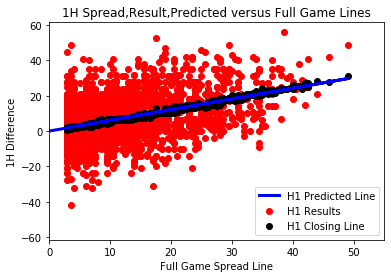

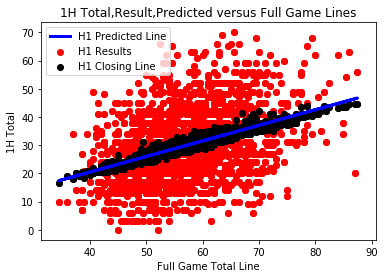

In [52]:
# Tried using both line and total as inputs for both but it made zero difference to accuracy.
# Single variable linear regression of full game lines is very basic but appears to match 1H closing lines.

plt.scatter(data_test[['line_p']], y_test_diff_results,  color='red')
plt.scatter(data_test[['line_p']], y_test_diff_line,  color='black')
plt.plot(data_test[['line_p']], y_pred_diff, color='blue', linewidth=3)
plt.title('1H Spread,Result,Predicted versus Full Game Lines')
plt.xlabel('Full Game Spread Line')
plt.ylabel('1H Difference')

# set x limit to 0. otherwise you'd see a mirror image for the negative spreads for the opponents
plt.xlim(0)
plt.legend(['H1 Predicted Line','H1 Results','H1 Closing Line'])
plt.show()

plt.scatter(data_test[['tot_p']], y_test_tot_results,  color='red')
plt.scatter(data_test[['tot_p']], y_test_tot_line,  color='black')
plt.plot(data_test[['tot_p']], y_pred_tot, color='blue', linewidth=3)
plt.title('1H Total,Result,Predicted versus Full Game Lines')
plt.xlabel('Full Game Total Line')
plt.ylabel('1H Total')
plt.legend(['H1 Predicted Line','H1 Results','H1 Closing Line'])
plt.show()

### 1H ODDS FUNCTION - Part of Parlay Pricer

In [53]:
## Create sub-function 
    ## input: full game spread/total and a desired 1H spread/total to be parlayed
    ## output: win/push probability for fav & over or dog & under depending on whether input is a fav or dog

## use train dataset to establish standard deviations for H1 spreads and total results
## note: square=false to get the ROOT MSE which is the standard deviation of the error from the predicted (mean) value.
sd_tot = mean_squared_error(data_train[['tot_h1']], data_train[['tot_p_h1']], squared=False)
sd_diff = mean_squared_error(data_train[['diff_h1']], data_train[['line_p_h1']], squared=False)
  
def odds (spread,total,H1_spread,H1_total):

    #establish mean H1 predictions using lin reg from before
    H1_spread_mean=reg_diff_h1.predict([[spread]])
    H1_total_mean=reg_tot_h1.predict([[total]])
    
    #SIMPLIFICATION - assume that alternate 1H spreads/totals are priced by making a normal distribution centered...
        # around a mean of the predicted 1H spread/total with a standard deviate = root mean squared error of the lin reg.
        # Likely that standard deviation changes depending on size of spread/total, but assuming constant for now.
        # Use normal distribution function to determine probablility of covering.
        # Again, not incorporating adjustments for "key numbers"
    
 
    #for favorites/over
    if H1_spread < 0:
        
        # check for push on spread- function defined above
        if (H1_spread)==int(H1_spread):
            
            #estimate of push probablility: for example for a spread of 3, find the cuml probability associated with 2.5 to 3.5 
            prob_push_spread=scipy.stats.norm(H1_spread_mean, sd_diff).cdf(H1_spread+0.5)-scipy.stats.norm(H1_spread_mean, sd_diff).cdf(H1_spread-0.5)
            
            # a favorite covering would a more negative number so it's equal to the cdf as opposed to 1-cdf (cuml density)
            # since there's a chance of a push, would need do probablility up until 2.5 if the spread is 3 
            prob_fav=scipy.stats.norm(H1_spread_mean, sd_diff).cdf(H1_spread-.5)
         
        else:
            
            prob_push_spread = 0
            # don't have to alter by 0.5 since no push probability
            prob_fav=scipy.stats.norm(H1_spread_mean, sd_diff).cdf(H1_spread)
            
        # check for push on total
        if (H1_total)==int(H1_total):
        
            prob_push_total=scipy.stats.norm(H1_total_mean, sd_tot).cdf(H1_total+0.5)-scipy.stats.norm(H1_total_mean, sd_tot).cdf(H1_total-0.5)
            prob_over=1-scipy.stats.norm(H1_total_mean, sd_tot).cdf(H1_total+0.5)
        
        else: 
           
            prob_push_total=0
            prob_over=1-scipy.stats.norm(H1_total_mean, sd_tot).cdf(H1_total)
        
        
        #decimal odds
        dec_fav = (1-prob_push_spread)/prob_fav
        dec_over = (1-prob_push_total)/prob_over
        
        
        print('\n\n Model Decimal Odds to bet Fav: \n%.2f' % dec_fav)
        print('\n Probability Fav covers: \n%.3f' % prob_fav)
        print(' Probability Spread Pushes: \n%.3f' % prob_push_spread)

        print('\n Model Decimal Odds to bet Over: \n%.2f' % dec_over)
        print('\n Probability Over covers: \n%.3f' % prob_over)
        print(' Probability Total Pushes: \n%.3f' % prob_push_total)

        
        return (prob_fav,prob_push_spread,dec_fav,prob_over,prob_push_total,dec_over) 
    
    #same for dogs/under
    else: 
        
        if (H1_spread)==int(H1_spread):
            
            prob_push_spread=scipy.stats.norm(H1_spread_mean, sd_diff).cdf(H1_spread+0.5)-scipy.stats.norm(H1_spread_mean, sd_diff).cdf(H1_spread-0.5)
            prob_dog=scipy.stats.norm(H1_spread_mean, sd_diff).cdf(H1_spread-0.5)

        else:
            
            prob_push_spread = 0
            prob_dog=scipy.stats.norm(H1_spread_mean, sd_diff).cdf(H1_spread)
    
        if (H1_total)==int(H1_total):
        
            prob_push_total=scipy.stats.norm(H1_total_mean, sd_tot).cdf(H1_total+0.5)-scipy.stats.norm(H1_total_mean, sd_tot).cdf(H1_total-0.5)
            prob_under=scipy.stats.norm(H1_total_mean, sd_tot).cdf(H1_total-0.5)
            
        else:
                
            prob_push_total = 0
            prob_under=scipy.stats.norm(H1_total_mean, sd_tot).cdf(H1_total)
    
        dec_dog= (1-prob_push_spread)/prob_dog
        dec_under = (1-prob_push_total)/prob_under
        
        print(' Model Decimal Odds to bet Dog: \n %.2f' % dec_dog)
        print('\n Probability Dog covers: \n %.3f' % prob_dog)
        print(' Probability Spread Pushes: \n %.3f' % prob_push_spread)

        print('\n Model Decimal Odds to bet Under: \n %.2f' % dec_under)
        print('\n Probability Under covers: \n %.3f' % prob_under)
        print(' Probability Total Pushes: \n %.3f' % prob_push_total)

        
        return (prob_dog,prob_push_spread,dec_dog,prob_under,prob_push_total,dec_under) 
        


In [54]:
# try out function
(prob_win_spread,prob_push_spread,dec_spread,prob_win_total,prob_push_total,dec_total) = odds(-14.5,49,-6.5,24)
print('\n\n',prob_win_spread)
print(prob_push_spread)
print(dec_spread)



 Model Decimal Odds to bet Fav: 
1.74

 Probability Fav covers: 
0.576
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.81

 Probability Over covers: 
0.533
 Probability Total Pushes: 
0.035


 [[0.57615074]]
0
[[1.73565689]]


## MODELING PARLAY CORRELATION
### Not the most efficient code segment but this only needs to be run once and doesn't need to run each time the parlay pricer is called since it's just creating a lookup table. 

In [55]:
## create blank dataframe for collecting correlation data
df_cor_loop = pd.DataFrame()
df_cor_loop = pd.DataFrame(columns = ['Spread','fav_%','dog_%','Total','over_%','under_%','f/o_%','d/u_%'])


## seperate into fav and dog dataframes to prevent double counting in some of the upcoming code
data_fav =data_train[data_train.line_p_h1<0]
data_dog =data_train[data_train.line_p_h1>0]

##denomintors for calculating percentages
denom_fav=data_fav.shape[0]
denom_dog=data_dog.shape[0]

## Nested loop to check different combinations of spreads and totals for all the games in the dataset.
## Check what % covers spread, total, and both in order to later generate a 'correlation %'
## Using all ".5" spreads/total to make the loop simpler. will interpolate correlation for whole number spreads/totals afterwards. 
for i_spread in np.arange(0.5,29.5,1):
    
    
    #calculate % of games where fav and dog cover a range of spreads

    fav_pct = data_fav['diff_h1'][data_fav['diff_h1']<(-i_spread)].count()/(denom_fav)
    dog_pct = data_dog['diff_h1'][data_dog['diff_h1']<(i_spread)].count()/(denom_dog)

    for i_total in np.arange(13.5,50.5,1):
        
        ##only if total>spread
        if i_total > i_spread:
            
            #calculate % of games where fav and dog cover a range of totals
            #this calculation doesn't actually have to be nested but the next one does 
            #can be improved to run faster, but still runs under 1 minute and this would NOT be part of the function that runs for every inquery so speed not as important
            over_pct = data_fav['tot_h1'][data_fav['tot_h1']>(i_total)].count()/(denom_fav)
            under_pct = data_dog['tot_h1'][data_dog['tot_h1']<(i_total)].count()/(denom_dog)
            
            # percent of favorite and over covering
            fo_pct = data_fav['tot_h1'][data_fav['tot_h1']>(i_total)][data_fav['diff_h1']<(-i_spread)].count()/(denom_fav)
            
            # percent of dog and under covering
            du_pct = data_dog['tot_h1'][data_dog['tot_h1']<(i_total)][data_dog['diff_h1']<(i_spread)].count()/(denom_dog)
        
            df_cor_loop=df_cor_loop.append(pd.DataFrame([[i_spread,fav_pct,dog_pct,i_total,over_pct,under_pct,fo_pct,du_pct]],##continue next line
            columns = ['Spread','fav_%','dog_%','Total','over_%','under_%','f/o_%','d/u_%']), ignore_index=True)

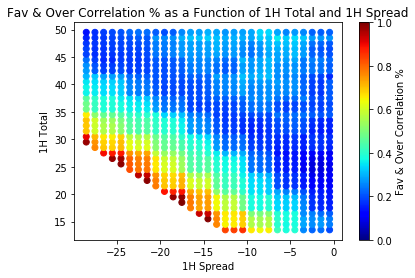

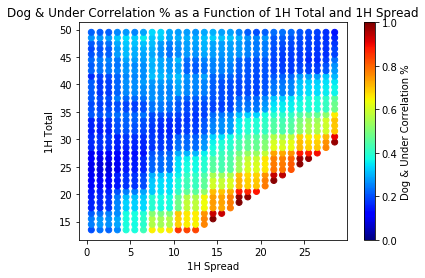

                Spread     Total  Spread/Total  cor_%_f/o
Spread        1.000000  0.228231      0.834816   0.402127
Total         0.228231  1.000000     -0.264807  -0.448255
Spread/Total  0.834816 -0.264807      1.000000   0.779090
cor_%_f/o     0.402127 -0.448255      0.779090   1.000000


In [56]:
##calculate % chance of win/win in uncorreleated parlay (% fav * % over. etc)
df_cor_loop['f%*o%']=(df_cor_loop['fav_%']*df_cor_loop['over_%'])
df_cor_loop['d%*u%']=(df_cor_loop['dog_%']*df_cor_loop['under_%'])

## % chance of lower probability event (fav or over and dog or under) 
## This is used in calculating corr % because this would be the probability of a fully correlated parlay
df_cor_loop['f/o%_min']=df_cor_loop[['fav_%','over_%']].min(axis=1)
df_cor_loop['d/u%_min']=df_cor_loop[['dog_%','under_%']].min(axis=1)

## Correlation % is calculated by where the % of fav&over cover lands between a fully independent scenario of
   ## (% of fav covers) * (% of over covers) = (% of both fav & over cover), which is 0% correlated
   ## to a scenario of min((% of fav cover),(% of overs cover)) = (% of both fav & over cover), which is 100% correlated.
## Same thing for dog and under.
##SIMPLIFICATION - Probaby main simplification in this challenge. Assuming correlation % for a spread/total combo...
    ## stays constant regards of what the "fair" 50/50 spread and total are. 
    ## In other words, the correlation % of spread of -14.5 & total of 28.5 is the same regardless of whether -14.5 & 28.5 are the -110 lines or -400 or +800 etc
    ## This doesn't mean parlay odds are the same for both those scenarios, just how the parlay correlation adjustment alters the uncorrelated parlay odds. 
df_cor_loop['cor_%_f/o']=(df_cor_loop['f/o_%']-df_cor_loop['f%*o%'])/(df_cor_loop['f/o%_min']-df_cor_loop['f%*o%'])
df_cor_loop['cor_%_d/u']=(df_cor_loop['d/u_%']-df_cor_loop['d%*u%'])/(df_cor_loop['d/u%_min']-df_cor_loop['d%*u%'])
df_cor_loop['Spread/Total']=df_cor_loop['Spread']/df_cor_loop['Total']

# not everyone likes the "jet" color scheme, but i think it's a lot clearer for this dataset. 
plt.scatter(-1*df_cor_loop['Spread'],df_cor_loop['Total'], c=df_cor_loop['cor_%_f/o'], vmin=0, vmax=1, alpha=1,cmap='jet')
plt.title('Fav & Over Correlation % as a Function of 1H Total and 1H Spread')
plt.xlabel('1H Spread')
plt.ylabel('1H Total')
plt.colorbar().set_label('Fav & Over Correlation %')
plt.show()

plt.scatter(df_cor_loop['Spread'],df_cor_loop['Total'], c=df_cor_loop['cor_%_d/u'], vmin=0, vmax=1, alpha=1,cmap='jet')
plt.title('Dog & Under Correlation % as a Function of 1H Total and 1H Spread')
plt.xlabel('1H Spread')
plt.ylabel('1H Total')
plt.colorbar().set_label('Dog & Under Correlation %')
plt.show()

print(df_cor_loop[['Spread','Total','Spread/Total','cor_%_f/o']].corr())

In [57]:
print('Fav/Over Corr Pct and Dog/Under Corr Pct is the same for a given spread/total. Max Difference/Error is: %.4f'
      % max(abs((df_cor_loop['cor_%_f/o']-df_cor_loop['cor_%_d/u']).min()),(df_cor_loop['cor_%_f/o']-df_cor_loop['cor_%_d/u']).max()))

Fav/Over Corr Pct and Dog/Under Corr Pct is the same for a given spread/total. Max Difference/Error is: 0.0029


/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


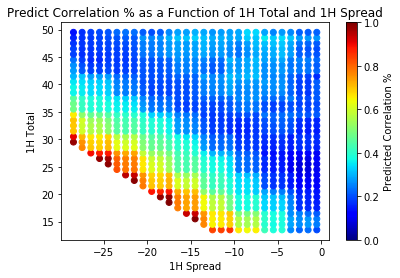

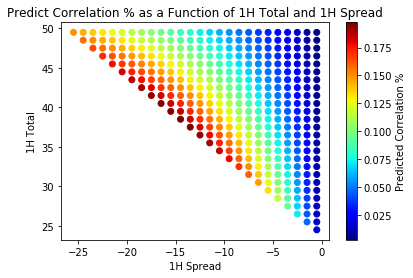

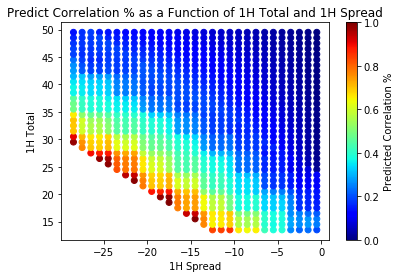

,Spread,fav_%,dog_%,Total,over_%,under_%,f/o_%,d/u_%,f%*o%,d%*u%,f/o%_min,d/u%_min,cor_%_f/o,cor_%_d/u,Spread/Total
count,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000
mean,13.193703,0.354710,0.645022,33.386873,0.375760,0.624008,0.173644,0.442841,0.144555,0.413779,0.246388,0.515620,0.277116,0.276939,0.415309
std,8.036714,0.195482,0.195550,10.019319,0.260041,0.260147,0.147887,0.223027,0.143915,0.227523,0.173161,0.218670,0.224511,0.224364,0.253609
min,0.500000,0.055329,0.315391,13.500000,0.046593,0.102798,0.008736,0.046444,0.002578,0.032422,0.046593,0.102798,0.002981,0.002981,0.010101
25%,6.500000,0.189672,0.456471,25.500000,0.145409,0.402837,0.053194,0.264283,0.033398,0.226591,0.102310,0.335406,0.113015,0.113093,0.200000
50%,12.500000,0.349058,0.650602,33.500000,0.354883,0.644967,0.123083,0.419743,0.086537,0.392545,0.189672,0.526428,0.194211,0.194127,0.402597
75%,19.500000,0.543001,0.810144,41.500000,0.596777,0.854450,0.258785,0.620482,0.214830,0.597595,0.353329,0.695686,0.393231,0.393078,0.604396
max,28.500000,0.684527,0.944617,49.500000,0.896913,0.953362,0.627839,0.906724,0.613962,0.900562,0.684527,0.944617,1.000000,1.000000,0.966102


In [58]:
## Want to smooth out the datapoints in the top corner. 
## The data is noisy there because there are less instances that fit the criteria of covering a high spread and/or a high total
## The goal is to keep as much of the high resolution data including the stepped regions that reflect inflection points at key numbers


## First cut away data in the corner above the (Spread + 23 = Total) line
## Remade it with a linear region based on extending the kept data outward

##seperated data
smooth_line=23
df_cor_smooth=df_cor_loop[(df_cor_loop['Spread']+smooth_line)<df_cor_loop['Total']]
df_cor_keep=df_cor_loop[(df_cor_loop['Spread']+smooth_line)>=df_cor_loop['Total']]

## did a linear fit based on the "kept" data to be used to replace the noisy removed data.
reg_cor = LinearRegression(fit_intercept=True).fit(df_cor_keep[['Spread','Spread/Total']], df_cor_keep['cor_%_f/o'])

## remade the noisy, low correlation corner using the linear fit and combined back together
cor_predict = reg_cor.predict(df_cor_smooth[['Spread','Spread/Total']])
df_cor_smooth['cor_%_f/o'] = cor_predict
df_cor_smooth['cor_%_d/u'] = cor_predict
df_cor=df_cor_smooth.append(df_cor_keep)

##comparison of original results and smoothing 

## plot original data
plt.scatter(-df_cor_loop['Spread'],df_cor_loop['Total'], c=df_cor_loop['cor_%_f/o'], vmin=0, vmax=1, alpha=1,cmap='jet')
plt.title('Predict Correlation % as a Function of 1H Total and 1H Spread')
plt.xlabel('1H Spread')
plt.ylabel('1H Total')
plt.colorbar().set_label('Predicted Correlation %')
plt.show()

## plot just smoothed part
plt.scatter(-df_cor_smooth['Spread'],df_cor_smooth['Total'], c=df_cor_smooth['cor_%_f/o'],  alpha=1,cmap='jet')
plt.title('Predict Correlation % as a Function of 1H Total and 1H Spread')
plt.xlabel('1H Spread')
plt.ylabel('1H Total')
plt.colorbar().set_label('Predicted Correlation %')
plt.show()

## plot final smooth
plt.scatter(-df_cor['Spread'],df_cor['Total'], c=df_cor['cor_%_f/o'], vmin=0, vmax=1, alpha=1,cmap='jet')
plt.title('Predict Correlation % as a Function of 1H Total and 1H Spread')
plt.xlabel('1H Spread')
plt.ylabel('1H Total')
plt.colorbar().set_label('Predicted Correlation %')
plt.show()



df_cor.describe()


In [59]:
## Interperolate current dataframe to add correlation % values for whole number spread/totals based on neighboring .5 spread/total values

for i_spread in np.arange(0.5,29,0.5):
    for i_total in np.arange(13.5,50,0.5):
        if (i_spread)==int(i_spread):
            if (i_total)==int(i_total):
                
                #both are new whole number spread total. average 4 surrounding values
                near1=df_cor[df_cor['Spread']==(i_spread+0.5)][df_cor['Total']==(i_total+0.5)]['cor_%_f/o'].max()
                near2=df_cor[df_cor['Spread']==(i_spread-0.5)][df_cor['Total']==(i_total+0.5)]['cor_%_f/o'].max()
                near3=df_cor[df_cor['Spread']==(i_spread-0.5)][df_cor['Total']==(i_total-0.5)]['cor_%_f/o'].max()
                near4=df_cor[df_cor['Spread']==(i_spread+0.5)][df_cor['Total']==(i_total-0.5)]['cor_%_f/o'].max()
                cor_pct_fo = statistics.mean([near1,near2,near3,near4])
                
                #established before that cor% for fav/over and dog/under are equal
                df_cor=df_cor.append(pd.DataFrame([[i_spread,i_total,cor_pct_fo,cor_pct_fo]],##continue next line
                columns = ['Spread','Total','cor_%_f/o','cor_%_d/u']), ignore_index=True)
                
            else:
                
                #just spread is a whole number
                near1=df_cor[df_cor['Spread']==(i_spread+0.5)][df_cor['Total']==(i_total)]['cor_%_f/o'].max()
                near2=df_cor[df_cor['Spread']==(i_spread-0.5)][df_cor['Total']==(i_total)]['cor_%_f/o'].max()
                cor_pct_fo = statistics.mean([near1,near2])
                
                df_cor=df_cor.append(pd.DataFrame([[i_spread,i_total,cor_pct_fo,cor_pct_fo]],##continue next line
                columns = ['Spread','Total','cor_%_f/o','cor_%_d/u']), ignore_index=True)
        else:
            if (i_total)==int(i_total):
                
                #just total is a whole number
                near1=df_cor[df_cor['Spread']==(i_spread)][df_cor['Total']==(i_total+0.5)]['cor_%_f/o'].max()
                near2=df_cor[df_cor['Spread']==(i_spread)][df_cor['Total']==(i_total-0.5)]['cor_%_f/o'].max()
                cor_pct_fo = statistics.mean([near1,near2])
                
                df_cor=df_cor.append(pd.DataFrame([[i_spread,i_total,cor_pct_fo,cor_pct_fo]],##continue next line
                columns = ['Spread','Total','cor_%_f/o','cor_%_d/u']), ignore_index=True)   

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [60]:
df_cor.head()

,Spread,Spread/Total,Total,cor_%_d/u,cor_%_f/o,d%*u%,d/u%_min,d/u_%,dog_%,f%*o%,f/o%_min,f/o_%,fav_%,over_%,under_%
0,0.5,0.020408,24.5,0.016802,0.016802,0.126193,0.315391,0.145356,0.315391,0.410371,0.599495,0.429431,0.684527,0.599495,0.400117
1,0.5,0.019608,25.5,0.015729,0.015729,0.127051,0.315391,0.146133,0.315391,0.408510,0.596777,0.427490,0.684527,0.596777,0.402837
2,0.5,0.018868,26.5,0.014737,0.014737,0.132383,0.315391,0.153129,0.315391,0.396949,0.579887,0.417589,0.684527,0.579887,0.419743
3,0.5,0.018182,27.5,0.013817,0.013817,0.151199,0.315391,0.168286,0.315391,0.356151,0.520287,0.373131,0.684527,0.520287,0.479401
4,0.5,0.017544,28.5,0.012961,0.012961,0.166031,0.315391,0.190051,0.315391,0.323991,0.473306,0.347894,0.684527,0.473306,0.526428


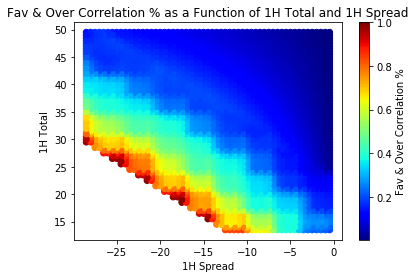

In [61]:
# print again with interpelated values
plt.scatter(-1*df_cor['Spread'],df_cor['Total'], c=df_cor['cor_%_f/o'], alpha=1,cmap='jet')
plt.title('Fav & Over Correlation % as a Function of 1H Total and 1H Spread')
plt.xlabel('1H Spread')
plt.ylabel('1H Total')
plt.colorbar().set_label('Fav & Over Correlation %')
plt.show()



### Lookup Function for Correlation

In [62]:
##input: Spread, Total 
##output: Correlation %

## reminder that correlation % for Fav/over and dog/under ended up being equal

def cor_look(spread,total):
    
    if spread >= total:
        cor_pct=1
    elif spread ==0:
        cor_pct=0
    else:
        try:
            cor_pct=df_cor[df_cor['Spread']==(abs(spread))][df_cor['Total']==(total)]['cor_%_f/o'].max()
        except: 
            print('\n Inputs out of range. \n\n Accetable range is a spread of: \n %.2f'% -df_cor['Spread'].max())
            print(' to %.2f'% df_cor['Spread'].max())
            print('\n and a Total of: \n %.2f'%df_cor['Total'].min())
            print(' to %.2f'%df_cor['Total'].max())
    
    return cor_pct

In [63]:
#example
cor_look(-23,29.5)

0.614631299689808

### American to Decimal Odds Function & Decimal to American Odds Function

In [64]:
#input: american odds
#output: decimal odds

def am_to_dec(american_odds):
    
    if american_odds>0:
        dec_odds = 1+american_odds/100
    else:
        dec_odds = 1-(100/american_odds)
        
    return dec_odds

#input: decimal odds
#output: american odds

def dec_to_am(dec_odds):
    
    if dec_odds>2:
        american_odds = (dec_odds-1)*100
    else:
        american_odds = -100/(dec_odds-1)
        
    return american_odds

## Top Level Function for H1 Parlay Pricing

In [65]:
#inputs: consensus full-game point spread & total, desired first half point spread/total and prices in american odds
#output: parlay price in american odds

def parlay_price(spread,total,H1_spread,H1_spread_price,H1_total,H1_total_price):
    
    # get win/push/loss probability for spread and total using previous defined function
    (prob_win_spread,prob_push_spread,dec_spread_model,prob_win_total,prob_push_total,dec_total_model)=odds(spread,total,H1_spread,H1_total)
    
    # calculate probability of the 3 push scenarios
    prob_spread_win_total_push = prob_win_spread * prob_push_total
    prob_total_win_spread_push = prob_win_total * prob_push_spread
    prob_push_push = prob_push_spread * prob_push_total
    prob_win_min = min(prob_win_spread,prob_win_total)
    
    
    # get correlation using other subfunction
    cor_pct = cor_look(H1_spread,H1_total)
    
    #calculate what the independent win/win probably would be 
    indep_prob_win_win = prob_win_spread * prob_win_total
    
    #calculate lower probability between spread and total covering to establish probability of corr=1 parlay
    min_prob_total_spread = min(prob_win_spread,prob_win_total)
    
    #adjust  win/win probability based on corr %
    prob_win_win = cor_pct*(prob_win_min - indep_prob_win_win)+indep_prob_win_win
        
    # convert from american to decimal odds
    dec_odd_spread = am_to_dec(H1_spread_price)
    dec_odd_total = am_to_dec(H1_total_price)

    indep_parlay_dec = dec_odd_spread*dec_odd_total
    
    # sum of probability of each outcome * each outcome decimal odds = 1
    # so 1 = win/win% * parlay odd + 1*push/push% + spread_odds*win-spread/push-total% + total_odds*win-total/push-spread%
    # rearrange to solve for parlay odds
    cor_parlay_dec= ((1 - 1*prob_push_push - dec_odd_spread*prob_spread_win_total_push - dec_odd_total*prob_total_win_spread_push)/prob_win_win).max()
    cor_parlay_am = dec_to_am(cor_parlay_dec)
    
    # calculate parlay odds just based on the H1 model. 
    # So accounting for spread/total price differences vs inputs but not accounting for correlation
    # useful as a check to see how much delta is from H1 model and how much is from correlation
    indep_model_parlay_dec= ((1 - 1*prob_push_push - dec_odd_spread*prob_spread_win_total_push - dec_odd_total*prob_total_win_spread_push)/indep_prob_win_win).max()
    
    # Earned Value for betting correlated parlay at uncorrelated odds
    EV=indep_parlay_dec/cor_parlay_dec-1
    
    print('\n Uncorrelated Parlay - Decimal: \n %.2f' % indep_parlay_dec)
    print(' Uncorrelated H1 Model Parlay - Decimal: \n %.2f' % indep_model_parlay_dec)
    print(' Correlated Parlay Price - Decimal: \n %.2f' % cor_parlay_dec)
    print('\n Correlation Percent: \n %.2f' % cor_pct)
    print(' Earned Value: \n %.2f' % EV)
    print('\n Correlated Parlay Price - American: \n %.0f' % cor_parlay_am)
   
    return pd.Series([cor_parlay_am, EV])

# Interface for Parlay Price

In [66]:
# should add checks and feedback on if the values entered make sense
# these entries would be boxes to populate on the GUI
spread = -36.5
total = 51
H1_spread = -22
H1_spread_price = 104
H1_total = 28.5
H1_total_price = -110
([cor_parlay_am, EV])=parlay_price(spread,total,H1_spread,H1_spread_price,H1_total,H1_total_price)



 Model Decimal Odds to bet Fav: 
1.98

 Probability Fav covers: 
0.489
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.32

 Probability Over covers: 
0.432
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.89
 Uncorrelated H1 Model Parlay - Decimal: 
 4.60
 Correlated Parlay Price - Decimal: 
 2.80

 Correlation Percent: 
 0.62
 Earned Value: 
 0.39

 Correlated Parlay Price - American: 
 180


### Test the Function using the Data_test set by Comparing projected EV to actual results

In [67]:
data_test_fav = data_test[data_test['line_p']<=0]
data_test_dog = data_test[data_test['line_p']>0]
data_test_fav.head()

,gameid,line_p,line_p_mon,tot_p,tot_p_omon,tot_p_umon,line_p_h1,line_p_mon_h1,tot_p_h1,tot_p_omon_h1,tot_p_umon_h1,season,week,diff_h1,tot_h1
12631,10327,-10.0,-112,64.0,-112.0,-102.0,-6.0,-112.0,32.0,-107.0,-107.0,2016,1,-2.0,22.0
12635,10329,-38.5,-106,58.5,-102.0,-112.0,-24.0,-106.0,34.5,-119.0,104.0,2016,1,-56.0,56.0
12638,10330,-13.5,-112,56.0,-102.0,-112.0,-7.5,-100.0,28.0,-111.0,-103.0,2016,1,-3.0,31.0
12643,10333,-21.5,102,58.0,100.0,-115.0,-12.5,-120.0,31.0,-107.0,-107.0,2016,1,10.0,16.0
12652,10337,-4.5,-102,40.5,-110.0,-104.0,-3.0,-103.0,20.0,-113.0,-101.0,2016,1,-10.0,10.0


In [68]:
## function to supress printed . otherwise will print for every row of data below

# Disable
def blockPrint():
    sys.__stdout__ = sys.stdout
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

In [69]:
blockPrint()

#run parlay pricer on all H1 spreads and totals in the "test" data set. 
#add column for parlay price and the project EV against a straight parlay using the independent odds. 
data_test_fav[['cor_par','EV']]= data_test_fav.apply(lambda x: parlay_price(x['line_p'],x['tot_p'],x['line_p_h1'],x['line_p_mon_h1'],x['tot_p_h1'],x['tot_p_omon_h1']),axis =1)
data_test_dog[['cor_par','EV']]= data_test_dog.apply(lambda x: parlay_price(x['line_p'],x['tot_p'],x['line_p_h1'],x['line_p_mon_h1'],x['tot_p_h1'],x['tot_p_umon_h1']),axis =1)

enablePrint()

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [70]:
#Function to determine parlay bet payout
#input: spread, total, spread odds, total odds,resulting point difference, resulting total.
#output: Profit for 1 Unit bet

def parlay_profit(H1_spread,H1_spread_price,H1_total,H1_total_price,res_diff,res_total):
    
    dec_odd_spread = am_to_dec(H1_spread_price)
    dec_odd_total = am_to_dec(H1_total_price)  
    indep_parlay_dec = dec_odd_spread*dec_odd_total
    
    #lose spread (more negative number is a win)
    if res_diff > H1_spread:
         profit=-1
    
    #push-push
    elif (H1_spread == res_diff) & (H1_total == res_total):
        profit=0
    
    #win spread & push total
    elif (res_diff < H1_spread) & (H1_total==res_total):
        profit=(dec_odd_spread-1)
    
    #fav/over path
    elif H1_spread < 0:
        
        #over total -> parlay fav/over win
        if (res_diff < H1_spread) & (res_total > H1_total):
            profit=(indep_parlay_dec-1)       
        
        # under total -> lose fav/over parlay
        elif res_total < H1_total:
            profit = -1

        #push spread & over/win total
        elif (H1_spread == res_diff) & (res_total > H1_total):
            profit=(dec_odd_total-1)
            
    #dog win spread
    elif H1_spread >= 0:
        
        #over total -> lose dog/under Parlay
        if (res_total > H1_total):
            profit=-1       
        
        # under total -> win dog/under parlay
        elif (res_diff < H1_spread) & (res_total < H1_total):
            profit = (indep_parlay_dec-1)

        #push spread & under/win total
        elif (H1_spread == res_diff) & (res_total < H1_total):
            profit=(dec_odd_total-1)
    
    return profit

        

In [71]:
data_test_fav['profit']= data_test_fav.apply(lambda x: parlay_profit(x['line_p_h1'],x['line_p_mon_h1'],x['tot_p_h1'],x['tot_p_omon_h1'],x['diff_h1'],x['tot_h1']),axis =1)
data_test_dog['profit']= data_test_dog.apply(lambda x: parlay_profit(x['line_p_h1'],x['line_p_mon_h1'],x['tot_p_h1'],x['tot_p_umon_h1'],x['diff_h1'],x['tot_h1']),axis =1)

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [72]:

# only sum of EV and profit for positive EV parlays. 
fav_over_pos_EV = data_test_fav['EV'][data_test_fav['EV']>0].sum()
dog_under_pos_EV = data_test_dog['EV'][data_test_dog['EV']>0].sum()
fav_over_pos_EV_profit = data_test_fav['profit'][data_test_fav['EV']>0].sum()
dog_under_pos_EV_profit = data_test_dog['profit'][data_test_dog['EV']>0].sum()
sum_pos_EV=fav_over_pos_EV+dog_under_pos_EV
sum_pos_EV_profit=fav_over_pos_EV_profit+dog_under_pos_EV_profit

print('\n Fav/Over sum EV of +EV parlays: \n %.2f' % fav_over_pos_EV)
print('\n Fav/Over sum profit of +EV parlays: \n %.2f' % fav_over_pos_EV_profit)
print('\n\n Dog/Under sum EV of +EV parlays: \n %.2f' % dog_under_pos_EV)
print('\n Dog/Under sum profit of +EV parlays: \n %.2f' % dog_under_pos_EV_profit)
print('\n\n Total sum EV of +EV parlays: \n %.2f' % sum_pos_EV)
print('\n Total sum profit of +EV parlays: \n %.2f' % sum_pos_EV_profit)




 Fav/Over sum EV of +EV parlays: 
 289.19

 Fav/Over sum profit of +EV parlays: 
 127.44


 Dog/Under sum EV of +EV parlays: 
 163.01

 Dog/Under sum profit of +EV parlays: 
 199.70


 Total sum EV of +EV parlays: 
 452.20

 Total sum profit of +EV parlays: 
 327.14


### Run same loop but assume every game was (erroniously) offering a +/-10 H1 spread and 28 H1 total for all games with the same -110ish odds 

In [73]:
blockPrint()

#run parlay pricer on all games in the test dataset, but bet a -10 spread, 28 total
#add column for parlay price and the project EV against a straight parlay using the independent odds. 

data_test_fav[['cor_par','EV']]= data_test_fav.apply(lambda x: parlay_price(x['line_p'],x['tot_p'],-10,x['line_p_mon_h1'],28,x['tot_p_omon_h1']),axis =1)
data_test_dog[['cor_par','EV']]= data_test_dog.apply(lambda x: parlay_price(x['line_p'],x['tot_p'],10,x['line_p_mon_h1'],28,x['tot_p_umon_h1']),axis =1)

enablePrint()

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [74]:
#this should have a bigger EV/profit because the line isn't efficient and it's decently correlated 
data_test_fav['profit']= data_test_fav.apply(lambda x: parlay_profit(-10,x['line_p_mon_h1'],28,x['tot_p_omon_h1'],x['diff_h1'],x['tot_h1']),axis =1)
data_test_dog['profit']= data_test_dog.apply(lambda x: parlay_profit(10,x['line_p_mon_h1'],28,x['tot_p_umon_h1'],x['diff_h1'],x['tot_h1']),axis =1)

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [75]:

    
# only sum of EV and profit for positive EV parlays. 
fav_over_pos_EV = data_test_fav['EV'][data_test_fav['EV']>0].sum()
dog_under_pos_EV = data_test_dog['EV'][data_test_dog['EV']>0].sum()
fav_over_pos_EV_profit = data_test_fav['profit'][data_test_fav['EV']>0].sum()
dog_under_pos_EV_profit = data_test_dog['profit'][data_test_dog['EV']>0].sum()
sum_pos_EV=fav_over_pos_EV+dog_under_pos_EV
sum_pos_EV_profit=fav_over_pos_EV_profit+dog_under_pos_EV_profit

print('\n Fav/Over sum EV of +EV parlays: \n %.2f' % fav_over_pos_EV)
print('\n Fav/Over sum profit of +EV parlays: \n %.2f' % fav_over_pos_EV_profit)
print('\n\n Dog/Under sum EV of +EV parlays: \n %.2f' % dog_under_pos_EV)
print('\n Dog/Under sum profit of +EV parlays: \n %.2f' % dog_under_pos_EV_profit)
print('\n\n Total sum EV of +EV parlays: \n %.2f' % sum_pos_EV)
print('\n Total sum profit of +EV parlays: \n %.2f' % sum_pos_EV_profit)



 Fav/Over sum EV of +EV parlays: 
 398.17

 Fav/Over sum profit of +EV parlays: 
 385.15


 Dog/Under sum EV of +EV parlays: 
 540.85

 Dog/Under sum profit of +EV parlays: 
 648.63


 Total sum EV of +EV parlays: 
 939.02

 Total sum profit of +EV parlays: 
 1033.78
